*The section on "Data retrieval using chembl_downloader" has been updated on 26th Jan 2024 - many thanks for the comment from Charles Tapley Hoyt (cthoyt)*.

##### **Brief introduction**

This post was really just an addition towards the last random forest (RF) post. It was mainly inspired by this paper [@esposito2021] from [rinikerlab](https://github.com/rinikerlab)[^1]. It was nice to complete the RF series by adding a RF classifier since last post was only on a regressor. Another thing was that imbalanced datasets were common in drug discovery projects, learning different strategies to deal with them was also very useful. While working on this post, I also came across a few other packages that I haven't used before so I've included them all down below.

[^1]: h/t: Greg Landrum for his comment on Mastodon for the last RF post (which led to this follow-up post)

<br>

##### **Overview of post**

-   Data sourcing via *chembl_downloader*
-   Minor data preprocessing using own little script and also SMILES checker from *scikit_mol*
- *scikit-learn*'s RandomForestClassifier()
-   Dealing with imbalanced dataset in RF classifiers by using *ghostml*
-   A small section on plotting receiver operating characteristic (ROC) curves

<br>

##### **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chembl_downloader
from chembl_downloader import latest, queries, query
from rdkit.Chem import Descriptors
import datamol as dm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve
from scikit_mol.utilities import CheckSmilesSanitazion
import ghostml

<br>

##### **Data retrieval using chembl_downloader**

chembl_downloader was something I wanted to try a while back. I've tried manual download and chembl_webresource_client previously, and they were probably not the best strategies for data reproducibility. The idea of chembl_downloader was to generate a reproducible ChEMBL data source. It involved some SQL at the beginning to specify the exact type of data needed, so some SQL knowledge were required. Other uses for this package were elaborated much more clearly in its GitHub repository at [https://github.com/cthoyt/chembl-downloader](https://github.com/cthoyt/chembl-downloader). One of the reference notebooks that I've used could be reached [here](https://github.com/cthoyt/chembl-downloader/blob/main/notebooks/drug-indications.ipynb) (more available in its repository).

What I did was shown below.

In [2]:
# Show the latest version of ChEMBL used
latest_version = latest()
print(f"The latest ChEMBL version is: {latest_version}")

The latest ChEMBL version is: 33


The code below took several minutes to run.

In [3]:
# Following data were 4.41GB in total from the SQL query

sql = """
SELECT
    ASSAYS.chembl_id              AS assay_chembl_id,
    TARGET_DICTIONARY.target_type,
    TARGET_DICTIONARY.tax_id,
    TARGET_DICTIONARY.chembl_id,
    COMPOUND_STRUCTURES.canonical_smiles,
    MOLECULE_DICTIONARY.chembl_id AS molecule_chembl_id,
    MOLECULE_DICTIONARY.max_phase,
    ACTIVITIES.standard_type,
    ACTIVITIES.pchembl_value
FROM TARGET_DICTIONARY
     JOIN ASSAYS ON TARGET_DICTIONARY.tid == ASSAYS.tid
     JOIN ACTIVITIES ON ASSAYS.assay_id == ACTIVITIES.assay_id
     JOIN MOLECULE_DICTIONARY ON MOLECULE_DICTIONARY.molregno == ACTIVITIES.molregno
     JOIN COMPOUND_STRUCTURES ON MOLECULE_DICTIONARY.molregno == COMPOUND_STRUCTURES.molregno
WHERE TARGET_DICTIONARY.chembl_id = 'CHEMBL220'
    AND ACTIVITIES.pchembl_value IS NOT NULL
    AND TARGET_DICTIONARY.target_type = 'SINGLE PROTEIN'
"""

I've updated how I retrieved and saved the ChEMBL data - code as suggested and provided by cthoyt. This would be a better and more reproducible way for anyone who might be interested in re-running this notebook.

In [4]:
from pathlib import Path

# Pick any directory, but make sure it's relative to your home directory
directory = Path.home().joinpath(".data", "blog")
# Create the directory if it doesn't exist
directory.mkdir(exist_ok=True, parents=True)

# Create a file path that corresponds to the version, since this could change
path = directory.joinpath(f"chembl_d_ache_{latest_version}.tsv")

if path.is_file():
    # If the file already exists, load it
    df_ache = pd.read_csv(path, sep=',')
else:
    # If the file doesn't already exist, make the query then cache it
    df_ache = chembl_downloader.query(sql)
    df_ache.to_csv(path, sep=",", index=False)

<br>

##### **Some data cleaning**

Minor cleaning and preprocessing were done for this post only, as the focus was more on dealing with imbalanced dataset in RF classifier. Since I used a different way to retrieve ChEMBL data this time, the dataset used here might be slightly different from the one used in previous post.

<br>

###### **mol_prep.py**

I've more or less accumulated small pieces of code over time, and I've decided to compile them into a Python script. The idea was to remove most function code in the post to avoid repeating them all the time since they've been used frequently in the last few posts. The script would be saved into the [RF repository](https://github.com/jhylin/ML2-2_random_forest), and would still be considered as a "work-in-progress" script (needs more work in the future).

In [5]:
## Trial own mol_prep.py script
from mol_prep import preprocess, rdkit_2d_descriptors

In [6]:
## Preprocess/standardise molecules
# Running preprocess function 
df_ache = df_ache.copy()
df_prep = df_ache.apply(preprocess, axis = 1)
df_prep.head(3)

,assay_chembl_id,target_type,tax_id,chembl_id,canonical_smiles,molecule_chembl_id,max_phase,standard_type,pchembl_value,rdkit_mol,standard_smiles,selfies,inchi,inchikey
0,CHEMBL1909212,SINGLE PROTEIN,9606,CHEMBL220,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL411,4.0,IC50,4.59,<rdkit.Chem.rdchem.Mol object at 0x134f4d3f0>,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,[C][C][/C][=Branch1][P][=C][Branch1][Ring1][/C...,InChI=1S/C18H20O2/c1-3-17(13-5-9-15(19)10-6-13...,RGLYKWWBQGJZGM-ISLYRVAYSA-N
1,CHEMBL1003053,SINGLE PROTEIN,9606,CHEMBL220,COc1c2occc2cc2ccc(=O)oc12,CHEMBL416,4.0,IC50,4.27,<rdkit.Chem.rdchem.Mol object at 0x134f4d540>,COc1c2occc2cc2ccc(=O)oc12,[C][O][C][=C][O][C][=C][C][Ring1][Branch1][=C]...,InChI=1S/C12H8O4/c1-14-12-10-8(4-5-15-10)6-7-2...,QXKHYNVANLEOEG-UHFFFAOYSA-N
2,CHEMBL2406149,SINGLE PROTEIN,9606,CHEMBL220,COc1c2occc2cc2ccc(=O)oc12,CHEMBL416,4.0,IC50,6.12,<rdkit.Chem.rdchem.Mol object at 0x134f4d5b0>,COc1c2occc2cc2ccc(=O)oc12,[C][O][C][=C][O][C][=C][C][Ring1][Branch1][=C]...,InChI=1S/C12H8O4/c1-14-12-10-8(4-5-15-10)6-7-2...,QXKHYNVANLEOEG-UHFFFAOYSA-N


<br>

###### **scikit_mol**

scikit_mol was a package originated from RDKit UGM hackathon in 2022. This [blog post](https://www.cheminformania.com/scikit-mol-easy-embedding-of-rdkit-into-scikit-learn/) elaborated further on its functions and uses in machine learning. For this post I've only used it for a very small portion, mainly to check for missing SMILES or errors in SMILES (kind of like double checking whether the preprocess function code worked as expected). It could be integrated with *scikit-learn*'s pipeline method for multiple estimators. Its GitHub Repository link: [https://github.com/EBjerrum/scikit-mol](https://github.com/EBjerrum/scikit-mol) - I've referred to this [reference notebook](https://github.com/EBjerrum/scikit-mol/blob/main/notebooks/05_smiles_sanitaztion.ipynb) while working on this post.

In [7]:
# Quick simple way to check for missing SMILES
print(f'Dataset contains {df_prep.standard_smiles.isna().sum()} unparsable mols')

Dataset contains 0 unparsable mols


In [8]:
# Checking for invalid SMILES using scikit_mol
smileschecker = CheckSmilesSanitazion()
smileschecker.sanitize(list(df_prep.standard_smiles))

# Showing SMILES errors
smileschecker.errors

,SMILES


It showed no errors in SMILES (errors should be listed in the code cell output).

In [9]:
## Generate RDKit 2D descriptors/fingerprints
# Running rdkit_2d_descriptors function
df_2d = rdkit_2d_descriptors(df_prep)
df_2d.head(3)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.41068,9.41068,0.284153,0.284153,0.779698,12.1000,268.356,248.196,268.146330,104,...,0,0,0,0,0,0,0,0,0,0
1,11.17310,11.17310,0.405828,-0.405828,0.586359,11.0625,216.192,208.128,216.042259,80,...,0,0,0,0,0,0,0,0,0,0
2,11.17310,11.17310,0.405828,-0.405828,0.586359,11.0625,216.192,208.128,216.042259,80,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Merge dataframes df_prep & df_2d via index
df_merge = pd.merge(
    df_prep[["max_phase", "molecule_chembl_id"]],
    df_2d,
    left_index=True,
    right_index=True
)
print(df_merge.shape)
df_merge.head(3)

(7144, 212)


,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.0,CHEMBL411,9.41068,9.41068,0.284153,0.284153,0.779698,12.1000,268.356,248.196,...,0,0,0,0,0,0,0,0,0,0
1,4.0,CHEMBL416,11.17310,11.17310,0.405828,-0.405828,0.586359,11.0625,216.192,208.128,...,0,0,0,0,0,0,0,0,0,0
2,4.0,CHEMBL416,11.17310,11.17310,0.405828,-0.405828,0.586359,11.0625,216.192,208.128,...,0,0,0,0,0,0,0,0,0,0


A different spreads of max phases were shown this time in the dataframe, as the SQL query mainly used IC50, whereas last post was strictly limited to Ki via ChEMBL web resource client. Other likely reason was that in the decision tree series, I've attempted data preprocessing at a larger scale so some data were eliminated. It appeared that there were more max phase 4 compounds here than last time (note: null compounds were not shown in the value counts as it was labelled as "NaN", it should be the largest max phase portion in the data).

In [11]:
# Find out counts of each max phase
df_merge.value_counts("max_phase")

max_phase
 4.0    618
-1.0     69
 2.0     29
 3.0     10
 1.0      7
 0.5      1
Name: count, dtype: int64

I then tried searching for the chembl_id of the 10 max phase 4 compounds used in the last post in the dataframe (df_merge).

In [12]:
# Previously used 10 max phase 4 compounds
# donepezil = CHEMBL502 & galantamine = CHEMBL659
list_mp4 = ["CHEMBL95", "CHEMBL1128", "CHEMBL640", "CHEMBL502", "CHEMBL481", "CHEMBL360055", "CHEMBL1025", "CHEMBL659", "CHEMBL1200970", "CHEMBL1677"]

# Search for compounds in list_mp4 within df_merge's "molecule_chembl_id" column
# using Series.isin
df_prev = df_merge.loc[df_merge["molecule_chembl_id"].isin(list_mp4)]
df_prev.head()

,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
9,4.0,CHEMBL481,13.581173,13.581173,0.095133,-1.863974,0.355956,22.209302,586.689,548.385,...,0,0,0,0,0,0,0,0,0,0
10,4.0,CHEMBL481,13.581173,13.581173,0.095133,-1.863974,0.355956,22.209302,586.689,548.385,...,0,0,0,0,0,0,0,0,0,0
67,4.0,CHEMBL95,6.199769,6.199769,0.953981,0.953981,0.706488,15.200000,198.269,184.157,...,0,0,0,0,0,0,0,0,0,0
68,4.0,CHEMBL95,6.199769,6.199769,0.953981,0.953981,0.706488,15.200000,198.269,184.157,...,0,0,0,0,0,0,0,0,0,0
69,4.0,CHEMBL95,6.199769,6.199769,0.953981,0.953981,0.706488,15.200000,198.269,184.157,...,0,0,0,0,0,0,0,0,0,0


There were many duplicates of compounds.

In [13]:
print(df_prev.shape)
df_prev.value_counts("molecule_chembl_id")

(439, 212)


molecule_chembl_id
CHEMBL95         182
CHEMBL502        143
CHEMBL659         76
CHEMBL1128        12
CHEMBL1677        10
CHEMBL1200970      6
CHEMBL640          4
CHEMBL1025         3
CHEMBL481          2
CHEMBL360055       1
Name: count, dtype: int64

In [14]:
# Dropping duplicated compound via chembl IDs in the main df
df_merge_new = df_merge.drop_duplicates(subset=["molecule_chembl_id"], keep="first")
print(df_merge_new.shape)
df_merge_new.head()

(5357, 212)


,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.0,CHEMBL411,9.410680,9.410680,0.284153,0.284153,0.779698,12.100000,268.356,248.196,...,0,0,0,0,0,0,0,0,0,0
1,4.0,CHEMBL416,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,...,0,0,0,0,0,0,0,0,0,0
3,-1.0,CHEMBL7002,11.591481,11.591481,0.189306,-0.309798,0.886859,23.608696,333.453,310.269,...,1,0,0,0,0,0,0,0,0,0
4,NaN,CHEMBL28,12.020910,12.020910,0.018823,-0.410347,0.631833,10.800000,270.240,260.160,...,0,0,0,0,0,0,0,0,0,0
5,4.0,CHEMBL41,12.564531,12.564531,0.203346,-4.329869,0.851796,12.909091,309.331,291.187,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Making sure previously used 10 max phase 4 compounds could be found in df_merge_new
df_mp4 = df_merge_new.loc[df_merge_new["molecule_chembl_id"].isin(list_mp4)]
df_mp4

,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
9,4.0,CHEMBL481,13.581173,13.581173,0.095133,-1.863974,0.355956,22.209302,586.689,548.385,...,0,0,0,0,0,0,0,0,0,0
67,4.0,CHEMBL95,6.199769,6.199769,0.953981,0.953981,0.706488,15.200000,198.269,184.157,...,0,0,0,0,0,0,0,0,0,0
249,4.0,CHEMBL502,12.936933,12.936933,0.108783,0.108783,0.747461,20.214286,379.500,350.268,...,0,0,0,0,0,0,0,0,0,0
508,4.0,CHEMBL640,11.743677,11.743677,0.044300,-0.044300,0.731540,10.529412,235.331,214.163,...,0,0,0,0,0,0,0,0,0,0
512,4.0,CHEMBL659,9.972866,9.972866,0.008380,-0.411699,0.800524,33.857143,287.359,266.191,...,0,0,0,0,0,0,0,0,0,0
1013,4.0,CHEMBL1025,12.703056,12.703056,0.426312,-4.304784,0.629869,13.000000,184.147,170.035,...,0,0,0,0,0,0,0,0,0,0
1345,4.0,CHEMBL1128,9.261910,9.261910,0.000000,0.000000,0.608112,10.692308,201.697,185.569,...,0,0,0,0,0,0,0,0,0,0
2028,4.0,CHEMBL360055,6.476818,6.476818,0.656759,0.656759,0.205822,12.583333,510.828,450.348,...,0,0,0,0,0,0,0,0,0,0
2725,4.0,CHEMBL1677,6.199769,6.199769,0.000000,0.000000,0.760853,14.250000,234.730,219.610,...,0,0,0,0,0,0,0,0,0,0
3271,4.0,CHEMBL1200970,2.520809,2.520809,0.000000,0.000000,0.709785,14.000000,348.943,323.743,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# note: compounds with max phase 0 not shown in the count
df_merge_new.value_counts("max_phase")

max_phase
 4.0    55
-1.0    26
 2.0     8
 3.0     7
 1.0     4
 0.5     1
Name: count, dtype: int64

<br>

##### **Model building**

The aim of this post was to model and classify the max phases of ChEMBL small molecules, i.e. whether the compounds in the testing set (consisted of max phase 0 or null compounds) might be eventually classified as max phase 4 or not. This was one of the approaches to answer the question in mind, and not the ultimate way to solve the problem (just thought to mention). The target was "max_phase" and features to be used were the various RDKit 2D descriptors (RDKit2D).

The steps I've taken to build the model were shown below:

1.  Re-labelled max phases as binary labels (e.g. max phase null as 0, max phase 4 as 1)

In [17]:
# Re-label max phase NaN as 0
df_merge_new = df_merge_new.fillna(0)
df_merge_new.head()

,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.0,CHEMBL411,9.410680,9.410680,0.284153,0.284153,0.779698,12.100000,268.356,248.196,...,0,0,0,0,0,0,0,0,0,0
1,4.0,CHEMBL416,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,...,0,0,0,0,0,0,0,0,0,0
3,-1.0,CHEMBL7002,11.591481,11.591481,0.189306,-0.309798,0.886859,23.608696,333.453,310.269,...,1,0,0,0,0,0,0,0,0,0
4,0.0,CHEMBL28,12.020910,12.020910,0.018823,-0.410347,0.631833,10.800000,270.240,260.160,...,0,0,0,0,0,0,0,0,0,0
5,4.0,CHEMBL41,12.564531,12.564531,0.203346,-4.329869,0.851796,12.909091,309.331,291.187,...,0,0,0,0,0,0,0,0,0,0


2.  Splitted data into max phase null & max phase 4 (needing to re-label max phase 4 column only as 1, and not disrupting the labels of max phase 0 compounds)

In [18]:
# Select all max phase null compounds
df_null = df_merge_new[df_merge_new["max_phase"] == 0]
print(df_null.shape)
df_null.head()

(5256, 212)


,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
4,0.0,CHEMBL28,12.020910,12.020910,0.018823,-0.410347,0.631833,10.800000,270.240,260.160,...,0,0,0,0,0,0,0,0,0,0
8,0.0,CHEMBL8320,10.282778,10.282778,0.120741,-0.120741,0.416681,17.500000,108.096,104.064,...,0,0,0,0,0,0,0,0,0,0
14,0.0,CHEMBL11833,11.201531,11.201531,0.428520,-0.466092,0.838024,25.157895,262.309,244.165,...,0,0,0,0,0,0,0,0,0,0
392,0.0,CHEMBL12324,11.257704,11.257704,0.462395,-0.462395,0.797990,26.150000,277.344,256.176,...,0,0,0,0,0,0,0,0,0,0
393,0.0,CHEMBL274107,11.359778,11.359778,0.372211,-0.473241,0.838024,25.157895,262.309,244.165,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Using pd.DataFrame.assign to add a new column to re-label max_phase 4 as "1"
df_mp4_lb = df_mp4.assign(max_phase_lb = df_mp4["max_phase"] / 4)

# Using pd.DataFrame.pop() & insert() to shift added column to first column position
first_col = df_mp4_lb.pop("max_phase_lb")
df_mp4_lb.insert(0, "max_phase_lb", first_col)
df_mp4_lb.head()

,max_phase_lb,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
9,1.0,4.0,CHEMBL481,13.581173,13.581173,0.095133,-1.863974,0.355956,22.209302,586.689,...,0,0,0,0,0,0,0,0,0,0
67,1.0,4.0,CHEMBL95,6.199769,6.199769,0.953981,0.953981,0.706488,15.200000,198.269,...,0,0,0,0,0,0,0,0,0,0
249,1.0,4.0,CHEMBL502,12.936933,12.936933,0.108783,0.108783,0.747461,20.214286,379.500,...,0,0,0,0,0,0,0,0,0,0
508,1.0,4.0,CHEMBL640,11.743677,11.743677,0.044300,-0.044300,0.731540,10.529412,235.331,...,0,0,0,0,0,0,0,0,0,0
512,1.0,4.0,CHEMBL659,9.972866,9.972866,0.008380,-0.411699,0.800524,33.857143,287.359,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Also create a new column max_phase_lb column for df_null 
# in order to merge 2 dfs later
df_null_lb = df_null.assign(max_phase_lb = df_null["max_phase"])
first_col_null = df_null_lb.pop("max_phase_lb")
df_null_lb.insert(0, "max_phase_lb", first_col_null)
df_null_lb.head()

,max_phase_lb,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
4,0.0,0.0,CHEMBL28,12.020910,12.020910,0.018823,-0.410347,0.631833,10.800000,270.240,...,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,CHEMBL8320,10.282778,10.282778,0.120741,-0.120741,0.416681,17.500000,108.096,...,0,0,0,0,0,0,0,0,0,0
14,0.0,0.0,CHEMBL11833,11.201531,11.201531,0.428520,-0.466092,0.838024,25.157895,262.309,...,0,0,0,0,0,0,0,0,0,0
392,0.0,0.0,CHEMBL12324,11.257704,11.257704,0.462395,-0.462395,0.797990,26.150000,277.344,...,0,0,0,0,0,0,0,0,0,0
393,0.0,0.0,CHEMBL274107,11.359778,11.359778,0.372211,-0.473241,0.838024,25.157895,262.309,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Concatenate df_mp4_lb & df_null_lb
df_full = pd.concat([df_null_lb, df_mp4_lb])
df_full

,max_phase_lb,max_phase,molecule_chembl_id,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
4,0.0,0.0,CHEMBL28,12.020910,12.020910,0.018823,-0.410347,0.631833,10.800000,270.240,...,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,CHEMBL8320,10.282778,10.282778,0.120741,-0.120741,0.416681,17.500000,108.096,...,0,0,0,0,0,0,0,0,0,0
14,0.0,0.0,CHEMBL11833,11.201531,11.201531,0.428520,-0.466092,0.838024,25.157895,262.309,...,0,0,0,0,0,0,0,0,0,0
392,0.0,0.0,CHEMBL12324,11.257704,11.257704,0.462395,-0.462395,0.797990,26.150000,277.344,...,0,0,0,0,0,0,0,0,0,0
393,0.0,0.0,CHEMBL274107,11.359778,11.359778,0.372211,-0.473241,0.838024,25.157895,262.309,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,1.0,4.0,CHEMBL1025,12.703056,12.703056,0.426312,-4.304784,0.629869,13.000000,184.147,...,0,0,0,0,0,0,0,0,0,0
1345,1.0,4.0,CHEMBL1128,9.261910,9.261910,0.000000,0.000000,0.608112,10.692308,201.697,...,0,0,0,0,0,0,0,0,0,0
2028,1.0,4.0,CHEMBL360055,6.476818,6.476818,0.656759,0.656759,0.205822,12.583333,510.828,...,0,0,0,0,0,0,0,0,0,0
2725,1.0,4.0,CHEMBL1677,6.199769,6.199769,0.000000,0.000000,0.760853,14.250000,234.730,...,0,0,0,0,0,0,0,0,0,0


3.  Defined X and y variables and trained RF classifier model

Eventually df_full contained 10 active compounds and 5256 inactive compounds (from the value counts).

In [22]:
df_full.value_counts("max_phase_lb")

max_phase_lb
0.0    5256
1.0      10
Name: count, dtype: int64

In [23]:
# Defining X (features) & y (target)
X = df_full.iloc[:, 3:]
y = df_full.iloc[:, 0]

In [24]:
# Checking right data were selected e.g. y as target
y

4       0.0
8       0.0
14      0.0
392     0.0
393     0.0
       ... 
1013    1.0
1345    1.0
2028    1.0
2725    1.0
3271    1.0
Name: max_phase_lb, Length: 5266, dtype: float64

In [25]:
# Convert both X & y to arrays
X = X.to_numpy()
y = y.to_numpy()

In [26]:
# Using train_test_split() this time to split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

After data splitting, a RF classifier was trained with reference to this [notebook](https://github.com/rinikerlab/GHOST/blob/main/notebooks/example_GHOST.ipynb).

In [27]:
# max_features = "sqrt" by default
rfc = RandomForestClassifier(max_depth=3, random_state=1, max_features="sqrt", oob_score=True)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, oob_score=True, random_state=1)

4.  Extracted positive prediction probabilities for the testing set and showed confusion matrix with classification metrics

In [28]:
test_probs = rfc.predict_proba(X_test)[:, 1]

Some reference links and explanations for area under the ROC curve and Cohen's Kappa.

**Area under the ROC curve**: [reference](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) - the area under a curve plot between *sensitivity* or *recall* (percent of all 1s classified correctly by a classifier or true positive rate) and *specificity* (percent of all 0s classified correctly by a classifier, or equivalent to 1 - false positive rate or true negative rate) [@bruce2020]. It is useful for evaluating the performance of a classification model via comparing the true positive rate and false positive rate which are influenced by shifting the decision threshold. Area under the ROC is usually represented as a number ranging from 0 to 1 (1 being a perfect classifier, 0.5 or below meaning a poor, ineffective classifier)

**Cohen's Kappa score**: [reference](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa) - a score that is used to measure the agreement of labelling between two annotators (usually between -1 and 1, the higher the score the better the agreement)

Rather than re-inventing the wheel, the following function code for calculating metrics of the RF model were adapted from [this notebook](https://github.com/rinikerlab/GHOST/blob/main/notebooks/example_GHOST.ipynb), from [GHOST repository](https://github.com/rinikerlab/GHOST). I have only added some comments for clarities, and also added a zero_division parameter for the classification_report to mute the warning message when the results ended up being 0 due to divisions by zero.

In [29]:
def calc_metrics(y_test, test_probs, threshold = 0.5):
    # Target label assigned according to stated decision threshold (default = 0.5)
    # e.g. second annotator (expected label)
    scores = [1 if x>=threshold else 0 for x in test_probs]
    # Calculate area under the ROC curve based on prediction score
    auc = metrics.roc_auc_score(y_test, test_probs)
    # Calculate Cohen's Kappa score
    # e.g. y_test as first annotator (predicted label)
    kappa = metrics.cohen_kappa_score(y_test, scores)
    # Formulate the confusion matrix
    confusion = metrics.confusion_matrix(y_test, scores, labels = list(set(y_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(y_test, scores, zero_division=0.0))
    return 

Note: roc_auc_score measures true positive and false positive rates, requiring binary labels (e.g. 0s and 1s) in the data

Then showed confusion matrix along with area under the ROC curve and Cohen's Kappa.

In [30]:
calc_metrics(y_test, test_probs, threshold = 0.5)

thresh: 0.50, kappa: 0.000, AUC test-set: 0.536
[[1052    0]
 [   2    0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1052
         1.0       0.00      0.00      0.00         2

    accuracy                           1.00      1054
   macro avg       0.50      0.50      0.50      1054
weighted avg       1.00      1.00      1.00      1054



To help with interpreting the confusion matrix, *scikit-learn* actually had a handy plotting code to visualise the matrix. 

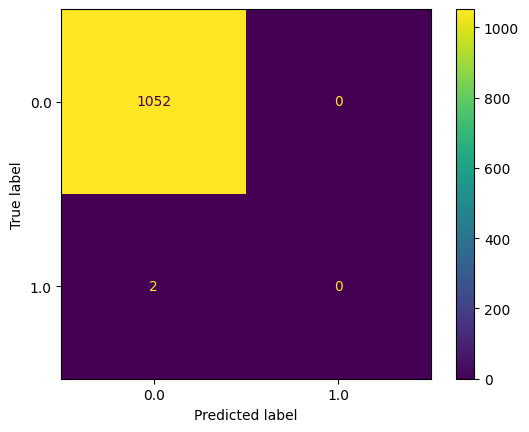

In [31]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test)
plt.show()

It was very obvious that not all of the compounds were classified in the testing set. There were only 1052 compounds classified as true negative, and none in the testing set were labelled as true positive. The likely reason was due to the very imbalanced ratio of actives (only 10 max phase 4 which were labelled as "1" compounds) and inactives (5256 max phase 0 compounds). Besides the imbalanced dataset, the decision threshold was also normally set at 0.5, meaning the classifier was likely going to lose the chance to classify the true positive compounds due to the very skewed ratio of actives to inactives.

5.  Two approaches were used in the GHOST (generalized threshold shifting) paper:

    -   Approach 1 (out-of-bag method, more computer efficient, aimed for RF classifiers) based on [RDKit blog post](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) or its [viewable notebook version](https://nbviewer.org/github/greglandrum/rdkit_blog/blob/master/notebooks/Working%20with%20unbalanced%20data%20part%201.ipynb) via nbviewer

    -   Approach 2 led to [GHOST](https://github.com/rinikerlab/GHOST) procedure with a goal to optimise and shift the decision threshold in any classification methods to catch the minor portion of actives (rather than the major portion of inactives) 

    - note: both approaches were shown to be performing similarly in the paper

I only used approach 2 here since the RDKit blog post had already explained approach 1 in depth. 

The next step involved extracting prediction probabilities from the RF classifier trained model.

In [32]:
# Get the positive prediction probabilities of the training set
train_probs = rfc.predict_proba(X_train)[:, 1]

6.  Used GHOST strategy in a postprocessing way (note: last post used data re-sampling method in a preprocessing way)

The decision threshold were optimised by using *ghostml* code via testing various different thresholds, e.g. in spaces of 0.05 that ranged from 0.05 to 0.5. The most optimal threshold would have the most maximised Cohen's kappa.

In [33]:
# Setting up different decision thresholds
thresholds = np.round(np.arange(0.05,0.55,0.05), 2)
thresholds

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [34]:
# Looking for the best threshold with the most optimal Cohen's Kappa
new_threshold = ghostml.optimize_threshold_from_predictions(y_train, train_probs, thresholds, ThOpt_metrics = 'ROC') 

Using the calc_metrics function again on the newly-found or shifted decision threshold.

In [35]:
calc_metrics(y_train, train_probs, threshold = new_threshold)

thresh: 0.10, kappa: 0.933, AUC test-set: 1.000
[[4204    0]
 [   1    7]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4204
         1.0       1.00      0.88      0.93         8

    accuracy                           1.00      4212
   macro avg       1.00      0.94      0.97      4212
weighted avg       1.00      1.00      1.00      4212



Here, after shifting the decision threshold with the most optimal Cohen's Kappa score, we could see an improved number of compounds labelled within the true negative class (increasing from 1052 to 4204), and more importantly, we could see the true positive class improved from 0 to 7 as well.

<br>

##### **Plotting ROC curves**

Time for some plots - I've shown two different ways to plot ROC curves below.

1.  Using *scikit-learn*

Testing set ROC curve - obviously, this was not a good classifier with a poor AUC.

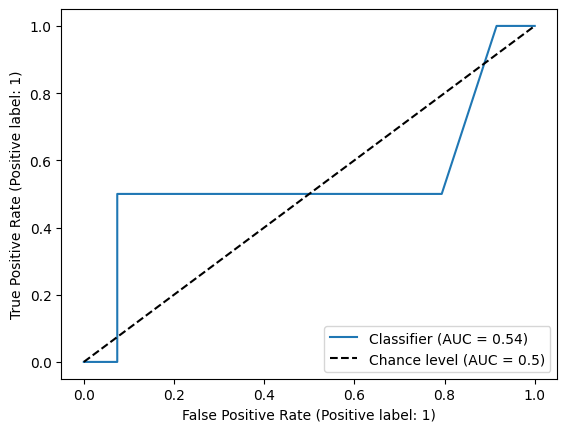

In [36]:
RocCurveDisplay.from_predictions(y_test, test_probs, plot_chance_level = True)

<br>

Training set ROC curve - this probably looked too good to be true or a textbook-standard ROC curve with AUC at 1.0.

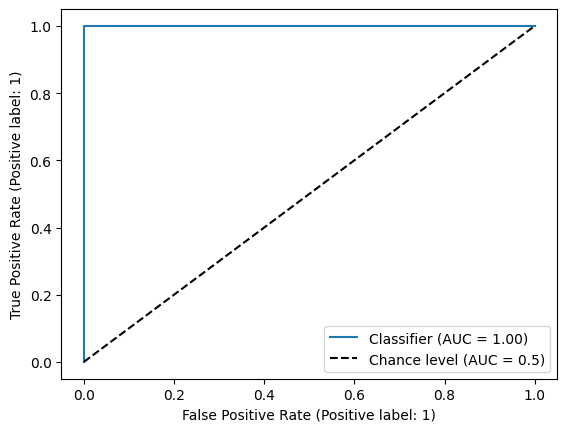

In [37]:
RocCurveDisplay.from_predictions(y_train, train_probs, plot_chance_level = True)

2.  Alternative method using matplotlib which reproduced a similar training set ROC plot:

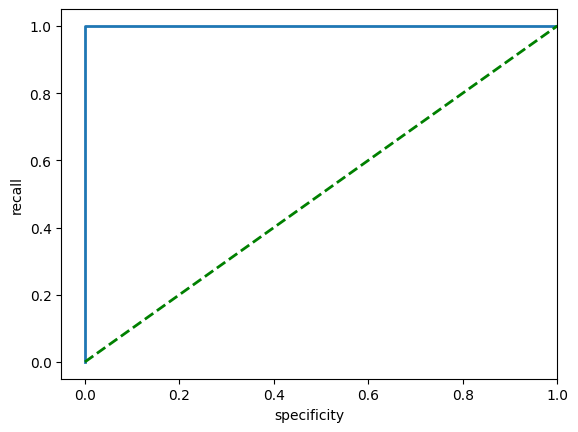

In [38]:
# Looking for true positive rate (tpr), false positive rate (fpr) & threshold
fpr, tpr, thresh = metrics.roc_curve(y_train, train_probs)
# Plotting
plt.figure()
# lw = linewidth
plt.plot(fpr, tpr, lw = 2)
# show random guessing line (threshold = 0.5)
plt.plot([0, 1], [0, 1], color = "g", lw = 2, linestyle="--")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.0])
plt.xlabel("specificity")
plt.ylabel("recall")
plt.show()

<br>

##### **Downsides and thoughts**

I wanted to mention that the testing set used here was most likely not the best ones to be used. There could be many overlaps or similarities between the training and testing sets, since they all came from ChEMBL database. For demonstration and learning purposes, I ended up using similar dataset as last time. Hopefully, I can try other open-source or public drug discovery datasets in the near future. 

The other thing to mention was that I should try different molecular fingerprints or descriptors as well, rather than only using RDKit2D, which might lead to different results. I should also probably slowly move onto using multiple datasets or targets in a project, which would likely make things more interesting. On the other hand, I also wanted to avoid this in order to make the topic of interest as clear and simple as possible for me or anyone who's trying to learn. 

<br>

##### **Acknowledgements**

I'd like to thank Riniker lab again for the GHOST paper, along with all the authors, contributors or developers for all of the software packages mentioned in this post, and also, huge thanks should also go to the authors of the reference notebooks mentioned in the post as well.